Import Data from File & Calculate \$\Delta$F/F

In [1]:
# Load raw data
import numpy as np
from wfield import load_stack
raw_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'
raw_file = 'ctb09_spontaneous_dark_run000_00000000_1_512_512_uint16.dat'
raw = load_stack(raw_path + raw_file)

# Grab reference frame for plotting
ref_frame = raw[1].squeeze().astype('float')

# Generate deltaF/F matrix
F = np.percentile(raw.squeeze(), 20, axis=0)
dFF = (raw.squeeze() - F)

Set Mask to Fit Cranial Window

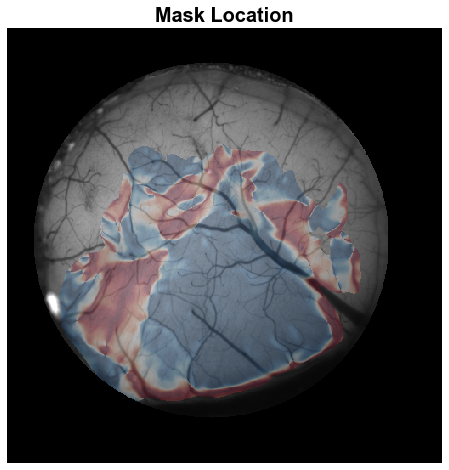

In [2]:
# Define crosshair cursor (from matplotlib documentation)
class Cursor:

    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()

# Plot reference frame and get user input for center and edge points of circular mask
import matplotlib.pyplot as plt
%matplotlib qt5
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.axis('off')
ax.set_title('Select Center Point and Edge Point for Circular Mask:', fontsize=20, color='k')
fig.set_size_inches(10, 10)
cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)
mask_coors = plt.ginput(n=2, timeout=-1)
plt.close('all')

# Generate mask and get indices to set as nan
import cv2
mask = np.zeros(ref_frame.shape, dtype=np.uint8)
radius = np.linalg.norm(np.array(mask_coors[1]) - np.array(mask_coors[0]))
circle = cv2.circle(mask, (int(mask_coors[0][0]),int(mask_coors[0][1])), int(radius), (255,255,255), -1).astype('float')
circle[circle == 255] = np.nan
mask_idx = (tuple(np.where(mask == 0)[0]), tuple(np.where(mask == 0)[1]))

# Load sign map
signmap_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
signmap_file = 'signmap.csv'
signmap = np.loadtxt(signmap_path + signmap_file)

# Plot reference frame and sign map to check mask placement
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.imshow(circle, cmap='gray', alpha=1)
ax.set_title('Mask Location', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

Mask Reference Frame & \$\Delta$F/F Matrix

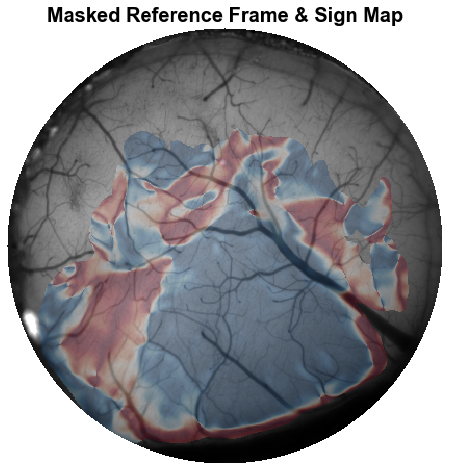

In [3]:
# Set pixel window size for correlation map
window_size = 2

# Mask reference frame and remove edges with all nan, accounting for pixel window size
np.add.at(ref_frame, mask_idx, np.nan)
row_mask = np.where(~np.isnan(ref_frame).all(axis=1))[0]
row_mask = row_mask[range(window_size * np.floor_divide(row_mask.shape[0], window_size))]
col_mask = np.where(~np.isnan(ref_frame).all(axis=0))[0]
col_mask = col_mask[range(window_size * np.floor_divide(col_mask.shape[0], window_size))]
edge_mask = np.ix_(row_mask, col_mask)
ref_frame = ref_frame[edge_mask]

# Mask sign map
np.add.at(signmap, mask_idx, np.nan)
signmap = signmap[edge_mask]

# Plot masked reference frame and sign map
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.set_title('Masked Reference Frame & Sign Map', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

# Mask deltaF/F matrix
dFF_masked = []
for frame in dFF:
     np.add.at(frame, mask_idx, np.nan)
     dFF_masked.append(frame[edge_mask])
dFF_masked = np.asarray(dFF_masked)

Get Visual Area Boundaries from Sign Map for Plotting against SCA Maps

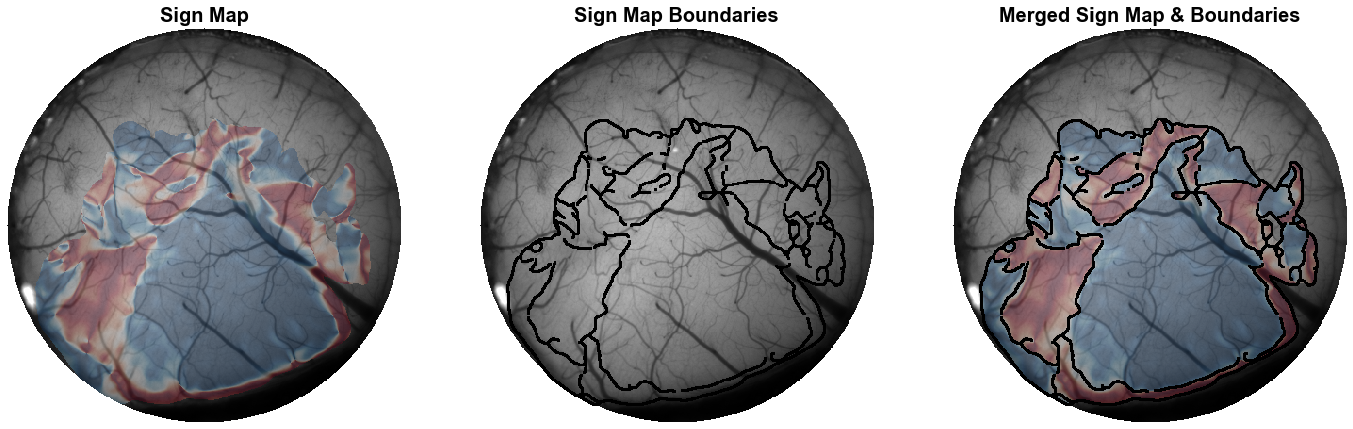

In [4]:
# Detect outer edges of sign map
signmap_threshold = signmap.copy()
kernel_edge = np.array([[-1, -1, -1],
                        [-1, 1, -1],
                        [-1, -1 , -1]])
for row in np.arange(1, signmap_threshold.shape[0] - 1):
    for col in np.arange(1, signmap_threshold.shape[1] - 1):
        curr_idx = np.ix_((row - 1, row, row + 1),(col - 1, col, col + 1))
        if not (np.isnan(signmap[row,col]) and
                    np.isnan(np.tensordot(kernel_edge, signmap_threshold[curr_idx], axes=((0,1),(0,1))))):
            signmap_threshold[curr_idx] = 0

# Threshold sign map around 0 to detect visual area boundaries
np.add.at(signmap_threshold, np.logical_or(signmap < -0.35, signmap > 0.35), np.nan)

# Skeletonize, then dilate thresholded sign map
from skimage.morphology import skeletonize
signmap_skeleton = skeletonize(~np.isnan(signmap_threshold))
kernel_dilate = np.ones((3, 3), np.uint8)
signmap_outline = cv2.dilate(signmap_skeleton.astype('float'), kernel_dilate, iterations=1)
signmap_outline[signmap_outline == 0] = np.nan

# Plot sign map, visual area boundaries, and merge
%matplotlib inline
fig, axs = plt.subplots(1,3)
axs[0].imshow(ref_frame, cmap='gray')
axs[0].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[0].set_title('Sign Map', fontsize=20, color='k')
axs[0].axis('off')
axs[1].imshow(ref_frame, cmap='gray')
axs[1].imshow(signmap_outline, cmap='Greys', clim=[0,1], alpha=1)
axs[1].set_title('Sign Map Boundaries', fontsize=20, color='k')
axs[1].axis('off')
axs[2].imshow(ref_frame, cmap='gray')
axs[2].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[2].imshow(signmap_outline, cmap='Greys', clim=[0,1], alpha=1)
axs[2].set_title('Merged Sign Map & Boundaries', fontsize=20, color='k')
axs[2].axis('off')
fig.set_size_inches(24, 8)

Select Seeds for SCA Maps

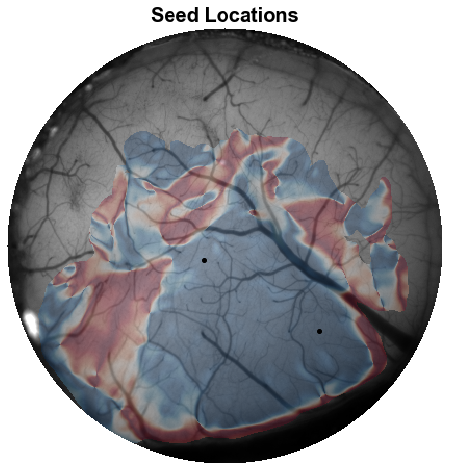

In [5]:
# Set number of seeds
num_seeds = 2

# Plot reference frame and sign map and get user input for seed locations
%matplotlib qt5
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.axis('off')
ax.set_title('Select {ns} Seeds:'.format(ns=num_seeds), fontsize=20, color='k')
fig.set_size_inches(10, 10)
coors = plt.ginput(n=num_seeds, timeout=-1)
plt.close('all')

# Rounds seed coordinates to nearest integer for matching to pixel index
round_coors = np.around(np.flip(coors, axis=1), decimals=0).squeeze()

# Plot seed locations against reference frame and sign map
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.scatter(round_coors[:,1], round_coors[:,0], color='k')
ax.set_title('Seed Locations', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

Generate SCA Maps

In [6]:
# Calculate SCA map for each seed location
import warnings
warnings.filterwarnings('ignore')
corr_mat = np.zeros((num_seeds, dFF_masked.shape[1], dFF_masked.shape[2]))
window_idx = np.arange(dFF_masked.shape[1]).reshape(int(dFF_masked.shape[1]/window_size), window_size)
for seed in range(num_seeds):
    seed_idx = np.where(window_idx == round_coors[seed][0])[0], np.where(window_idx == round_coors[seed][1])[0]
    seed_window = window_idx[seed_idx[0],:].squeeze(), window_idx[seed_idx[1],:].squeeze()
    seed_mean = dFF_masked[np.ix_(range(dFF_masked.shape[0]),seed_window[0],seed_window[1])].mean(axis=(1,2))
    for row_idx in window_idx:
        for col_idx in window_idx:
            curr_mean = dFF_masked[np.ix_(range(dFF_masked.shape[0]),row_idx,col_idx)].mean(axis=(1,2))
            if np.isnan(curr_mean).any():
                corr_mat[np.ix_(np.array([seed]),row_idx,col_idx)] = np.tile(np.nan,(window_size,window_size))
            else:
                PCC = np.corrcoef(seed_mean,curr_mean)
                corr_mat[np.ix_(np.array([seed]),row_idx,col_idx)] = np.tile(PCC[1,0],(window_size,window_size))

Plot Individual SCA Maps for each Seed

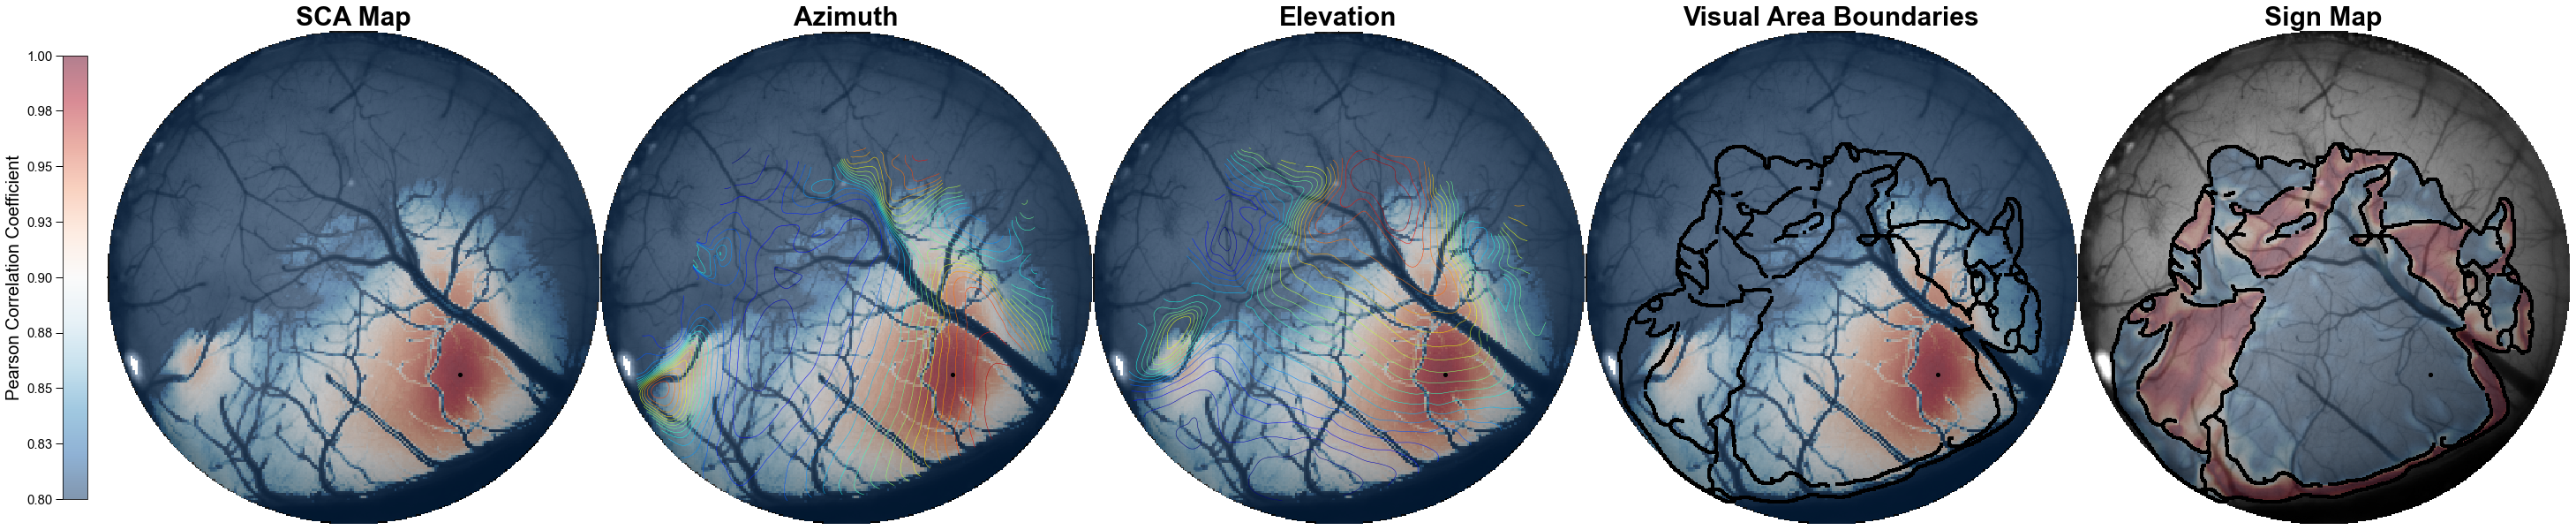

In [7]:
# Set colormap bounds for plotting SCA map
corr_bounds = [0.8, 1.0]

# Find or make directory for writing individual SCA maps
import os
ind_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/' \
           + 'SCA_ind_{lb}_{ub}'.format(lb=corr_bounds[0], ub=corr_bounds[1])
if not os.path.isdir(ind_path): 
    os.mkdir(ind_path)

# Load and mask azimuth and elevation data
azimuth_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
azimuth_file = 'azimuth.csv'
azimuth = np.loadtxt(azimuth_path + azimuth_file)
np.add.at(azimuth, mask_idx, np.nan)
azimuth = azimuth[edge_mask]
elevation_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
elevation_file = 'elevation.csv'
elevation = np.loadtxt(elevation_path + elevation_file)
np.add.at(elevation, mask_idx, np.nan)
elevation = elevation[edge_mask]

# Plot SCA map, SCA map + azimuth, SCA map + elevation, SCA map + visual area boundaries, and sign map + visual area boundaries
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
for seed in range(num_seeds):
    fig, axs = plt.subplots(1, 5)
    # SCA map
    axs[0].imshow(ref_frame, cmap='gray')
    axs[0].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[0].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[0].set_title('SCA Map', fontsize=30, color='k')
    axs[0].axis('off')
    cax = inset_axes(axs[0], width='5%', height='90%', loc='center left', borderpad=-5)
    colorbar = fig.colorbar(axs[0].images[1], cax=cax)
    colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cax.tick_params(labelsize=15)
    # SCA map + azimuth
    axs[1].imshow(ref_frame, cmap='gray')
    axs[1].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[1].contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
    axs[1].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[1].set_title('Azimuth', fontsize=30, color='k')
    axs[1].axis('off')
    # SCA map + elevation
    axs[2].imshow(ref_frame, cmap='gray')
    axs[2].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[2].contour(elevation, levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
    axs[2].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[2].set_title('Elevation', fontsize=30, color='k')
    axs[2].axis('off')
    # SCA map + visual area bounds
    axs[3].imshow(ref_frame, cmap='gray')
    axs[3].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[3].imshow(signmap_outline, cmap='Greys', clim=[0, 1], alpha=1)
    axs[3].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[3].set_title('Visual Area Boundaries', fontsize=30, color='k')
    axs[3].axis('off')
    # Sign map + visual area bounds
    axs[4].imshow(ref_frame, cmap='gray')
    axs[4].imshow(signmap, cmap='RdBu_r', clim=[-1, 1], alpha=0.3)
    axs[4].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[4].imshow(signmap_outline, cmap='Greys', clim=[0, 1], alpha=1)
    axs[4].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[4].set_title('Sign Map', fontsize=30, color='k')
    axs[4].axis('off')
    fig.set_size_inches(50, 15)
    fig.patch.set_facecolor('w')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(ind_path + '/seed{sd}.png'.format(sd=seed))
    if seed is not num_seeds - 1: 
        plt.close()

Plot SCA Maps for all Seeds

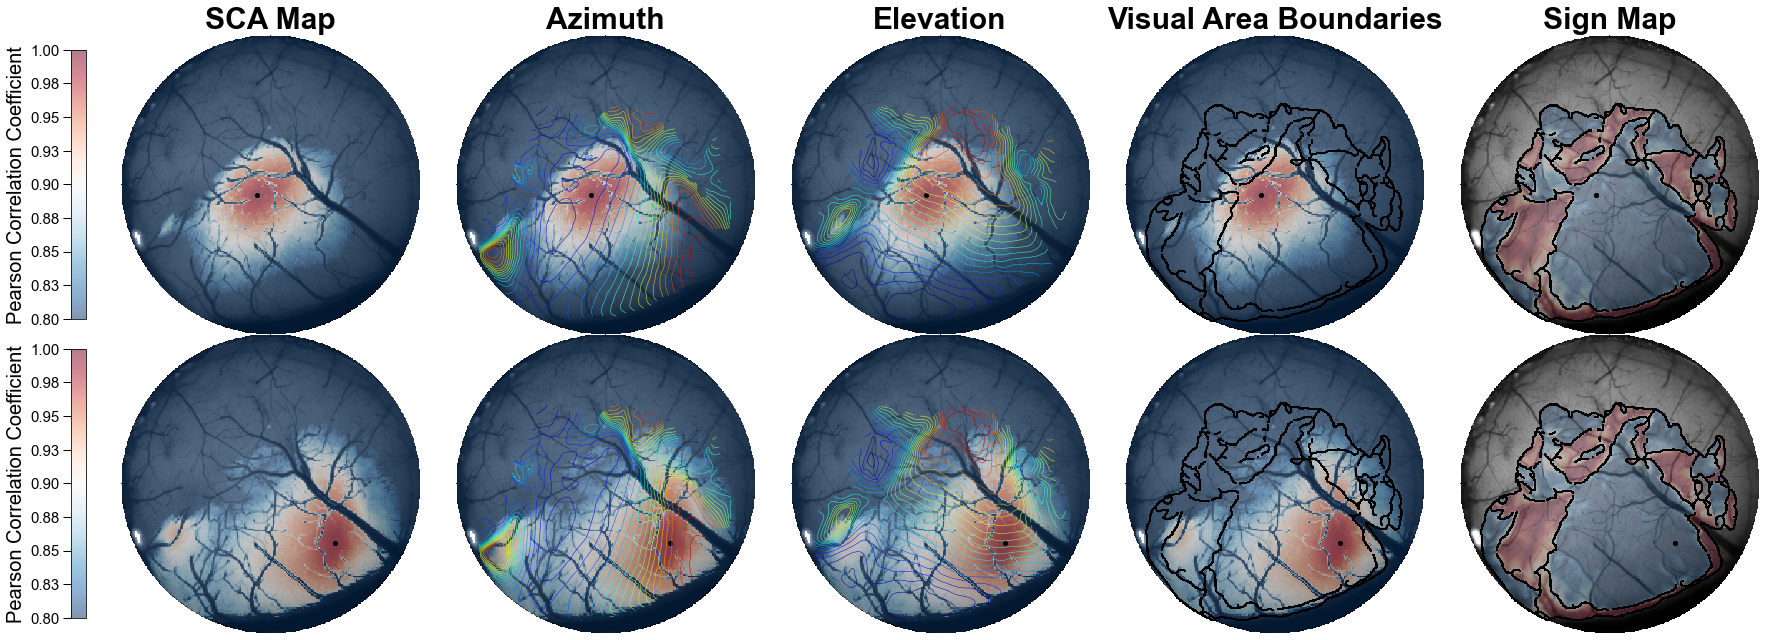

In [8]:
# Set directory for writing combined SCA maps
all_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'

# For all seeds (rows), plot SCA map, SCA map + azimuth, SCA map + elevation, SCA map + visual area bounds, and sign map + visual area bounds
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(num_seeds,5)
for seed in range(num_seeds):
    # SCA map
    axs[seed,0].imshow(ref_frame, cmap='gray')
    axs[seed,0].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[seed,0].scatter(coors[seed][0], coors[seed][1], color='k')
    if seed == 0: axs[seed,0].set_title('SCA Map', fontsize=30, color='k')
    axs[seed,0].axis('off')
    cax = inset_axes(axs[seed,0], width='5%', height='90%', loc='center left', borderpad=-5)
    colorbar = fig.colorbar(axs[seed,0].images[1], cax=cax)
    colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cax.tick_params(labelsize=15)
    # SCA map + azimuth
    axs[seed,1].imshow(ref_frame, cmap='gray')
    axs[seed,1].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[seed,1].contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
    axs[seed,1].scatter(coors[seed][0], coors[seed][1], color='k')
    if seed == 0: axs[seed,1].set_title('Azimuth', fontsize=30, color='k')
    axs[seed,1].axis('off')
    # SCA map + elevation
    axs[seed,2].imshow(ref_frame, cmap='gray')
    axs[seed,2].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[seed,2].contour(elevation, levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
    axs[seed,2].scatter(coors[seed][0], coors[seed][1], color='k')
    if seed == 0: axs[seed,2].set_title('Elevation', fontsize=30, color='k')
    axs[seed,2].axis('off')
    # SCA map + visual area bounds
    axs[seed,3].imshow(ref_frame, cmap='gray')
    axs[seed,3].imshow(corr_mat[seed], cmap='RdBu_r', clim=corr_bounds, alpha=0.5)
    axs[seed,3].imshow(signmap_outline, cmap='Greys', clim=[0, 1], alpha=1)
    axs[seed,3].scatter(coors[seed][0], coors[seed][1], color='k')
    if seed == 0: axs[seed,3].set_title('Visual Area Boundaries', fontsize=30, color='k')
    axs[seed,3].axis('off')
    # Sign map + visual area bounds
    axs[seed,4].imshow(ref_frame, cmap='gray')
    axs[seed,4].imshow(signmap, cmap='RdBu_r', clim=[-1, 1], alpha=0.3)
    axs[seed,4].scatter(coors[seed][0], coors[seed][1], color='k')
    axs[seed,4].imshow(signmap_outline, cmap='Greys', clim=[0, 1], alpha=1)
    axs[seed,4].scatter(coors[seed][0], coors[seed][1], color='k')
    if seed == 0: axs[seed,4].set_title('Sign Map', fontsize=30, color='k')
    axs[seed,4].axis('off')
fig.set_size_inches(30, num_seeds*5.5)
fig.patch.set_facecolor('w')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(all_path + 'SCA_all_{lb}_{ub}.png'.format(lb=corr_bounds[0], ub=corr_bounds[1]))